In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
url = 'https://raw.github.com/kevynalifian/ML/main/yoghurt_exp1.xlsx'

# Baca file Excel dari URL
data = pd.read_excel(url)

# Tampilkan data
print(data)

          Negara  Tahun  Harga   Volume kg   Volume  Harga Pertons
0          World   2000  75.11     68116.0  68.1160       1.102678
1       Honduras   2000  33.73     37814.0  37.8140       0.891998
2    Netherlands   2000  22.20     11466.0  11.4660       1.936159
3        Germany   2000  15.70     10168.0  10.1680       1.544060
4          Tonga   2000   2.80      8339.0   8.3390       0.335772
..           ...    ...    ...         ...      ...            ...
307       Brunei   2021  40.07     26550.1  26.5501       1.509222
308  Korea, Rep.   2021  37.89     26160.0  26.1600       1.448394
309        Japan   2021  23.93     16421.6  16.4216       1.457227
310    Australia   2021   5.76      1386.0   1.3860       4.155844
311     Malaysia   2021   1.41       511.0   0.5110       2.759295

[312 rows x 6 columns]


In [ ]:
df = pd.DataFrame(data)

In [ ]:
print(df['Negara'].value_counts())

 World                        22
Tonga                         19
Hong Kong, China              17
East Timor                    16
Singapore                     15
                              ..
Ethiopia(excludes Eritrea)     1
Poland                         1
Tunisia                        1
Qatar                          1
Guyana                         1
Name: Negara, Length: 69, dtype: int64


## Try Modelling 1

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten, BatchNormalization

In [ ]:
# Load dataset and filter for "jepang"
df_jepang = df[df["Negara"] == "East Timor"]
data_olah = df_jepang[["Tahun", "Harga Pertons"]]

In [ ]:
#prices = df_jepang["Harga (per-ton)"].to_numpy()

In [ ]:
# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_olah[["Harga Pertons"]])

In [ ]:
# Split data into train and test sets
train_size = int(len(scaled_data) * 0.8)
train, test = scaled_data[0:train_size], scaled_data[train_size:]

In [ ]:
train_size

12

In [ ]:
# Create sequences for LSTM
seq_length = 4
def create_sequences(data_olah, seq_length):
    sequences = []
    for i in range(len(data_olah) - seq_length):
        sequence = data_olah[i:i + seq_length]
        sequences.append(sequence)
    return np.array(sequences)


train_sequences = create_sequences(train, seq_length)
test_sequences = create_sequences(test, seq_length)

In [ ]:
# Prepare data for CNN
#train_sequences = np.expand_dims(train_sequences, axis = 1)
#test_sequences = np.expand_dims(test_sequences, axis = 1)

In [ ]:
# Prepare data for training and testing
train_sequences = np.array(train_sequences)
test_sequences = np.array(test_sequences)

In [ ]:
test_sequences.shape

(0,)

In [ ]:
# Build CNN-LSTM model
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=3, activation="relu", input_shape=(seq_length, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(1))
model.compile(loss="mae", optimizer="adam", metrics = ["mse"])

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mse')<0.02):
      print("\nReached 0.04 mse so cancelling training!")
      self.model.stop_training = True
callbacks = myCallback()

In [ ]:
# Train the model
model.fit(train_sequences, train[seq_length:], epochs=100, batch_size=32, validation_data=(train_sequences, train[seq_length:]))

Epoch 1/100
1/1 [==============================] - 6s 6s/step - loss: 0.2542 - mse: 0.0911 - val_loss: 0.2451 - val_mse: 0.0855
Epoch 2/100
1/1 [==============================] - 0s 60ms/step - loss: 0.2451 - mse: 0.0855 - val_loss: 0.2364 - val_mse: 0.0801
Epoch 3/100
1/1 [==============================] - 0s 44ms/step - loss: 0.2364 - mse: 0.0801 - val_loss: 0.2274 - val_mse: 0.0748
Epoch 4/100
1/1 [==============================] - 0s 63ms/step - loss: 0.2274 - mse: 0.0748 - val_loss: 0.2179 - val_mse: 0.0695
Epoch 5/100
1/1 [==============================] - 0s 61ms/step - loss: 0.2179 - mse: 0.0695 - val_loss: 0.2077 - val_mse: 0.0641
Epoch 6/100
1/1 [==============================] - 0s 63ms/step - loss: 0.2077 - mse: 0.0641 - val_loss: 0.1965 - val_mse: 0.0586
Epoch 7/100
1/1 [==============================] - 0s 44ms/step - loss: 0.1965 - mse: 0.0586 - val_loss: 0.1866 - val_mse: 0.0530
Epoch 8/100
1/1 [==============================] - 0s 60ms/step - loss: 0.1866 - mse: 0.0530

In [ ]:
# Train the model
predicted_prices = []
year_to_predict = [2023, 2024, 2025, 2026, 2027]
num_future_years = 4  # Adjust this parameter

# Update the prediction logic to iterate over multiple years
for i in range(num_future_years):
    future_sequence = scaled_data[-seq_length:]
    future_sequence = np.expand_dims(future_sequence, axis=0)
    future_sequence = np.expand_dims(future_sequence, axis=2)

    predicted_price = model.predict(future_sequence)[0][0]
    predicted_price = scaler.inverse_transform(np.array([[predicted_price]]))[0][0]
    predicted_prices.append(predicted_price)

    # Update the future sequence for the next year
    scaled_data = np.append(scaled_data, [predicted_price])
    scaled_data = scaled_data[1:]

1/1 [==============================] - 0s 32ms/step


In [ ]:
predicted_prices

[0.61672014, 1.0063097, 1.0052547, 0.57397866]

In [ ]:
#predicted_prices

In [ ]:
# Combine actual and predicted prices
actual_prices = data_olah["Harga Pertons"].values[train_size:]
all_prices = np.concatenate((actual_prices, predicted_prices))

In [ ]:
#predicted_price = scaler.inverse_transform(np.array([[predicted_price]]))[0][0]

In [ ]:
tahun_grafik = data_olah["Tahun"].to_numpy()
harga_grafik = data_olah["Harga Pertons"].to_numpy()

In [ ]:
#predicted_prices[0]

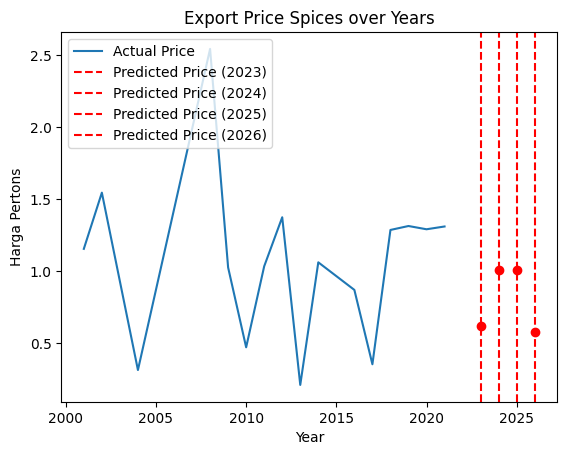

In [ ]:
#data_olah[["Harga (per-ton)"]]
# Plot actual and predicted prices
plt.plot(tahun_grafik, harga_grafik, label="Actual Price")
#plt.plot(range(2022, 2022 + 2), predicted_price)
for i in range(num_future_years):
      plt.axvline(x=year_to_predict[i], color="red", linestyle="--", label=f"Predicted Price ({year_to_predict[i]})")
      plt.scatter(year_to_predict[i], predicted_prices[i], color="red", marker="o")


# Add labels and title
plt.xlabel("Year")
plt.ylabel("Harga Pertons")
plt.title("Export Price Spices over Years")

# Add legend
plt.legend()

# Display the plot
plt.show()

In [ ]:
# Predict price for next year
#year_to_predict = [2023, 2024, 2025, 2026]   # Adjust this year
# Create a list to store the predicted prices
#predicted_prices = []

# Iterate over the years to predict
#for year in year_to_predict:
#    # Get the future sequence
#    future_sequence = scaled_data[(-(year + 1)) * seq_length:]
#    future_sequence = np.expand_dims(future_sequence, axis=0)

    # Predict the price
#    predicted_price = model.predict(future_sequence)[0, 0]

    # Scale the predicted price back to original range
#    predicted_price = np.array([[predicted_price]])

#    predicted_price = scaler.inverse_transform(predicted_price)[0, 0]



    # Add the predicted price to the list#
#    predicted_prices.append(predicted_price)


##Saved Model

In [ ]:
model.save('Yogurt(Hong Kong, China).h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
